In [1]:
import sys; sys.path.insert(0, '..')
from ldf.best_subset import best_n_avg
from ldf.ldf import ldf
import pandas as pd
import numpy as np
from scipy.stats import norm
import scipy.stats as st
import itertools
from tqdm.auto import tqdm
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
mpl.rcParams.update({'errorbar.capsize': 2})

sns.set_style("whitegrid")
sns.set_context("paper", rc={"font.size":8,"axes.titlesize":20,"axes.labelsize":20})
plt.rc('legend',fontsize=16)
SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Loss Discounting Framework - simulation study

## Data Generating Process
$$
y_t = x_t + \sigma_y \epsilon_t\\
x_t = \phi_x x_{t-1} + \sigma_x v_t
$$

Forecasters receive noisy signals:
$$
z_{kt} = x_t + \sigma_{zk} \nu_{kt}
$$

### Fix the seed for reproducibility

In [2]:
np.random.seed(0)

### Define DGP constants

In [3]:
phi = 0.9
sigma_x = 0.3 # 1# 
sigma_y = 0.3 # 0.5 # 
sigma_z = 0.1 # 1# 

In [4]:
K = 20  # number of forecasters
T = 2001  ## number of time steps

### Functions to generate the process

In [5]:
# Definition of time-constant Markov transition matrix
def generate_levels():
    transitions = np.asarray([-1, 0, 1])
    transition_matrix = np.array([[0.99, 0.005, 0.005],[0.005, 0.99, 0.005],[0.005, 0.005, 0.99]]) # np.array([[0.98, 0.01, 0.01],[0.01, 0.98, 0.01],[0.01, 0.01, 0.98]])
    levels = [0]
    for i in range(1,T):  
        level_index = np.where(transitions == levels[-1])[0][0]
        levels.append(np.random.choice(transitions, replace=True, p=transition_matrix[level_index]))
    return np.asarray(levels)

In [6]:
# Definition of time-varying Markov transition matrix
def generate_levels2():
    transitions = np.asarray([-1, 0, 1])
    transition_matrix = np.array([[0.99, 0.005, 0.005],[0.005, 0.99, 0.005],[0.005, 0.005, 0.99]])
    transition_matrix2 = np.array([[0.98, 0.01, 0.01],[0.01, 0.98, 0.01],[0.01, 0.01, 0.98]])
    levels = [0]
    for i in range(1,T):  
        level_index = np.where(transitions == levels[-1])[0][0]
        if i<1000:
            levels.append(np.random.choice(transitions, replace=True, p=transition_matrix[level_index]))
        else:
            levels.append(np.random.choice(transitions, replace=True, p=transition_matrix2[level_index]))
    return np.asarray(levels)

In [7]:
# Define levels of the process
levels = np.asarray([0]*50 + [-1]*50 + [1]*50 + [-1]*50 + [0]*200 + [-1]*400 + [0]*50 + [-1]*50 + [1]*50 + [-1]*10 + [1]*10 + [0]*10 + [-1]*10 + [1]*10  + [0]*50 + [1]*50 + [0]*50 + [-1]*50 + [1]*400 + [0]*50 + [-1]*50 + [1]*50 + [0]*50 + [0]*201)

def generate_dgp(levels):
    v_t = norm.rvs(size=T)
    e_t = norm.rvs(size=T)
    x = np.asarray([sigma_x * v_t[0]])
    for i in range(T-1):
        x = np.append(x, phi * x[-1] + sigma_x * v_t[i+1])
    y = phi * x + e_t * sigma_y
    y = y + levels
    return x, y

In [8]:
def get_forecasts(levels):
    x, y = generate_dgp(levels)
    z = x + norm.rvs(size=(K,T)) * sigma_z
    p = z # phi * z
    p = (p.T + np.linspace(-2,2,K)).T
    forecasts = pd.DataFrame(p)
    return forecasts, y

### Generate forecasts

In [9]:
#levels = generate_levels()
forecasts, y = get_forecasts(levels)

### Forecasters's logarithmic scores

In [10]:
forecasts_lik = pd.DataFrame(norm.pdf(y, loc=forecasts.to_numpy(), scale=sigma_y))
forecasts_cdf = pd.DataFrame(norm.cdf(y, loc=forecasts.to_numpy(), scale=sigma_y))  # forecasters's cdfs

## Loss Discounting Framework

In [11]:
discount_factors = np.array([1, 0.99, 0.95, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.001])
c = 10**-20 
log_likelihoods = np.log(forecasts_lik).astype(float).to_numpy()

### 2-level LDF(softmax, argmax)

In [12]:
%%time
res_ldf_1 = ldf(log_likelihoods, levels=2, discount_factors=[discount_factors, discount_factors], activation_functions=["softmax", "argmax"], c=c)
res_ldf_1_df = pd.DataFrame([discount_factors, res_ldf_1["logscores"][:,-1981:].mean(axis=1)]).T
res_ldf_1_df

Wall time: 4.1 s


,0,1
0,1.000,-0.474122
1,0.990,-0.451394
2,0.950,-0.437226
3,0.900,-0.440357
4,0.800,-0.457975
5,0.700,-0.465743
6,0.600,-0.467819
7,0.500,-0.470843
8,0.400,-0.471271
9,0.300,-0.475496


### 2-level LDF(softmax, softmax)

In [13]:
%%time
res_ldf_2 = ldf(log_likelihoods, levels=2, discount_factors=[discount_factors, discount_factors], activation_functions=["softmax", "softmax"], c=c)
res_ldf_2_df = pd.DataFrame([discount_factors, res_ldf_2["logscores"][:,-1981:].mean(axis=1)]).T
res_ldf_2_df

Wall time: 226 ms


,0,1
0,1.000,-0.472197
1,0.990,-0.437319
2,0.950,-0.405530
3,0.900,-0.397657
4,0.800,-0.395212
5,0.700,-0.397274
6,0.600,-0.400026
7,0.500,-0.402842
8,0.400,-0.405781
9,0.300,-0.408715


#### Probability Integral Transform - analysis

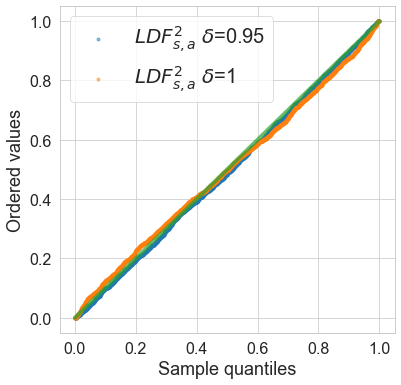

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(6,6))
(x_1, y_1) , _ = st.probplot((forecasts_cdf.T[20:] * res_ldf_1["weights"][4][-1981:]).sum(axis=1), dist="uniform")
(x_2, y_2) , _ = st.probplot((forecasts_cdf.T[20:] * res_ldf_1["weights"][0][-1981:]).sum(axis=1), dist="uniform")
ax.plot([0,1], [0,1], color="tab:green", lw=4, alpha=0.7)
ax.scatter(x_1, y_1, marker="o", s=10, alpha=0.5, color="tab:blue", label=r"$LDF_{s, a}^2$ $\delta$=0.95")
ax.scatter(x_2, y_2, marker="o", s=10, alpha=0.5, color="tab:orange", label=r"$LDF_{s, a}^2$ $\delta$=1")
ax.legend()
ax.set_xlabel("Sample quantiles")
ax.set_ylabel("Ordered values")
plt.show()

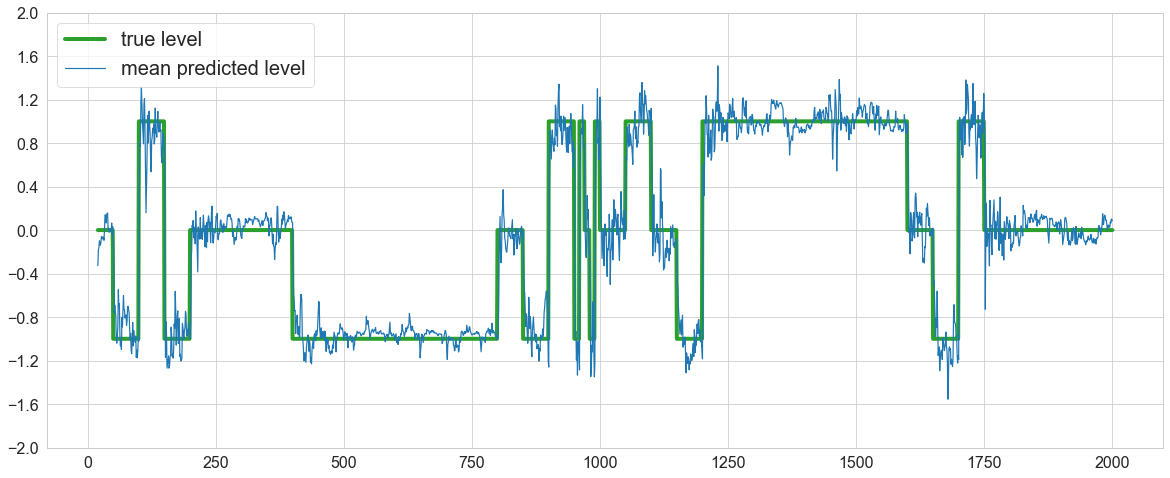

In [18]:
mean_pred_level = (np.linspace(-2,2,20) * res_ldf_2["weights"][2][-1981:]).sum(axis=1)
sns.color_palette("tab10")
fig, ax = plt.subplots(1, 1, figsize=(20,8))
lns1 = ax.plot(range(20, len(levels)), levels[20:], lw=4, label="true level", color="tab:green")
lns2 = ax.plot(range(20, len(levels)), mean_pred_level , label="mean predicted level", color="tab:blue")
lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax.set_ylim(-2, 2)
ax.set_yticks(np.arange(-2, 2.4, 0.4))
ax.legend(lns, labs, loc=2)

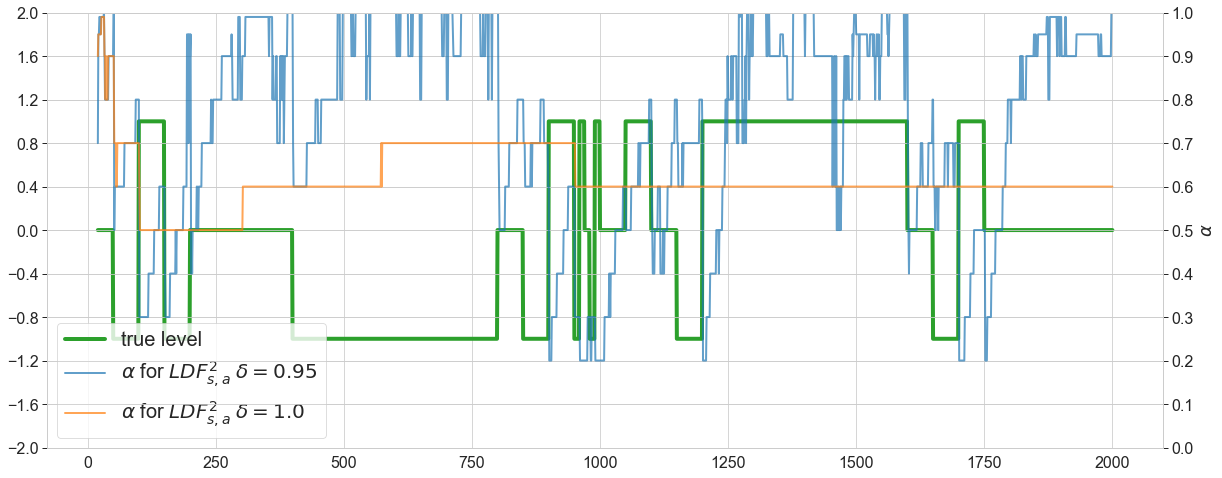

In [19]:
_temp = res_ldf_1["params_weights"][2][-1981:] * discount_factors
alpha_levels_1 = (_temp)[np.nonzero(_temp)]
_temp = res_ldf_1["params_weights"][0][-1981:] * discount_factors
alpha_levels_2 = (_temp)[np.nonzero(_temp)]

fig, ax = plt.subplots(1, 1, figsize=(20,8))
lns1 = ax.plot(range(20, len(levels)), levels[20:], lw=4, label="true level", color="tab:green")
ax2 = ax.twinx()
lns2 = ax2.plot(range(20, len(levels)), alpha_levels_1, c="tab:blue", alpha=0.7, label=r'$\alpha$ for $LDF_{s, a}^2$ $\delta=0.95$', lw=2)
lns3= ax2.plot(range(20, len(levels)), alpha_levels_2, c="tab:orange", alpha=0.7, label=r'$\alpha$ for $LDF_{s, a}^2$ $\delta=1.0$', lw=2)

lns = lns1+lns2 + lns3
labs = [l.get_label() for l in lns]
ax.set_ylim(-2, 2)
ax.set_yticks(np.arange(-2, 2.4, 0.4))
ax2.set_ylim(0, 1)
ax2.set_yticks(np.arange(0, 1.1, 0.1))
ax2.set_ylabel(r"$\alpha$")
ax.legend(lns, labs, loc=3);

### Diebold (2021) - best-N forecasters results

In [20]:
n = 4  # size of the team of forecasters to find
rolling_window_length = 5
comb = list(set(itertools.combinations(np.arange(K), n)))
comb = [list(t) for t in comb]

In [21]:
avg_forecasts_loglik = pd.DataFrame(np.asarray([np.log(forecasts_lik.loc[c].mean()) for c in comb]))
max_idx = avg_forecasts_loglik.rolling(rolling_window_length, min_periods=rolling_window_length, axis=1).mean().idxmax()
best_4_loglik = np.asarray([avg_forecasts_loglik.loc[idx][j+1] for idx, j in zip(max_idx[-1981:], avg_forecasts_loglik.columns[19:-1])])

In [22]:
best_combs = [comb[int(i)] for i in max_idx[-1981:]]
best_predictions = [np.asarray([forecasts.loc[i][j+1] for i in best_combs[j]]).mean() for j in range(len(max_idx[19:-1]))]
mean_pred_level_avg =  [np.asarray([np.linspace(-2,2,20)[i] for i in best_combs[j]]).mean() for j in range(len(max_idx[19:-1]))] 

In [23]:
best_4_loglik.mean()

-0.24390278422583597

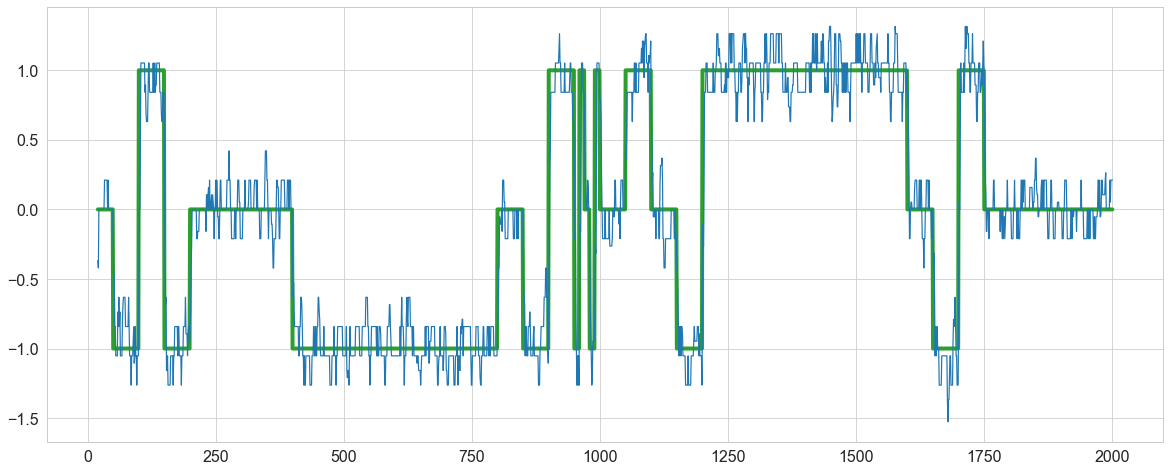

In [24]:
sns.color_palette("tab10")
fig, ax = plt.subplots(1, 1, figsize=(20,8))
ax.plot(range(20, len(levels)), levels[20:], lw=4, color="tab:green")
ax.plot(range(20, len(levels)), mean_pred_level_avg);

## Bayesian Predictive Synthesis (McAlinn, West 2019)

In [43]:
log_lik = np.load(r"..//data//BPS//loglik_5000_95beta_95delta.npy")
expectations = np.load(r"..//data//BPS//E_p_5000_95beta_95delta.npy")
variances = np.load(r"..//data//BPS//V_p_5000_95beta_95delta.npy")
errors = np.load(r"..//data/BPS//e_5000_95beta_95delta.npy")
ys = np.load(r"..//data//BPS//ys.npy")

In [44]:
np.log(np.mean(log_lik, axis=1)).mean()

-0.7289656462920973

In [45]:
np.log(np.mean(log_lik, axis=1)).sum()

-1444.0809453046447

## Full experiment

In [46]:
np.random.seed(0)
results = {"bma": [], "avg": []}
results_cumulative = {"bma": [], "avg": []}
# results = {"bma": []}
num_runs = 10
windows = [5] # rolling window length
ns = [1, 2, 3, 4, 5, 6] # [1] # 
discount_factors = np.array([1, 0.99, 0.95, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.001])
c = 10**-20 

# dense settings
#alphas = np.linspace(0.2, 1.0, 81)
#deltas = np.linspace(0.2, 1.0, 81)

c = 10**-20 # 0 # 
levels = np.asarray([0]*50 + [-1]*50 + [1]*50 + [-1]*50 + [0]*200 + [-1]*400 + [0]*50 + [-1]*50 + [1]*50 + [-1]*10 + [1]*10 + [0]*10 + [-1]*10 + [1]*10  + [0]*50 + [1]*50 + [0]*50 + [-1]*50 + [1]*400 + [0]*50 + [-1]*50 + [1]*50 + [0]*50 + [0]*201)
#levels = np.ones(len(levels))
for run in tqdm(range(num_runs)):
    levels = levels # generate_levels2() # levels #generate_levels2()
    forecasts, y = get_forecasts(levels)
    forecasts_lik = norm.pdf(y, loc=forecasts, scale=sigma_y)
    
    for n in ns:
        comb = list(set(itertools.combinations(np.arange(K), n)))
        comb = [list(t) for t in comb]
        forecasts_lik_df = pd.DataFrame(forecasts_lik)
        avg_forecasts_loglik = pd.DataFrame(np.asarray([np.log(forecasts_lik_df.loc[c].mean()) for c in comb]))
        results["avg"].append(np.log(forecasts_lik.mean(axis=0))[20:].mean())
        results_cumulative["avg"].append(np.log(forecasts_lik.mean(axis=0))[20:].sum())
        for rolling_window_length in windows:
            max_idx = avg_forecasts_loglik.rolling(rolling_window_length, min_periods=rolling_window_length, axis=1).sum().idxmax()
            best_n_loglik = np.asarray([avg_forecasts_loglik.loc[idx][j+1] for idx, j in zip(max_idx[19:], avg_forecasts_loglik.columns[19:-1])])
            if "avg_" + str(n) + "_" + str(rolling_window_length) not in results.keys():
                results["avg_" + str(n) + "_" + str(rolling_window_length)] = []
                results_cumulative["avg_" + str(n) + "_" + str(rolling_window_length)] = []
            results["avg_" + str(n) + "_" + str(rolling_window_length)].append(best_n_loglik.mean())
            results_cumulative["avg_" + str(n) + "_" + str(rolling_window_length)].append(best_n_loglik.sum())
    
    log_likelihoods = np.log(forecasts_lik)
    res = ldf(log_likelihoods, levels=2, discount_factors=[discount_factors, discount_factors], activation_functions=["softmax", "argmax"], c=c)
    for j, delta in enumerate(discount_factors):
        if "ldfa_" + str(delta) not in results.keys():
            results["ldfa_" + str(delta)] = []
            results_cumulative["ldfa_" + str(delta)] = []
        results["ldfa_" + str(delta)].append(res["logscores"][j][19:].mean())
        results_cumulative["ldfa_" + str(delta)].append(res["logscores"][j][19:].sum())
        
        
    log_likelihoods = np.log(forecasts_lik)
    res = ldf(log_likelihoods, levels=2, discount_factors=[discount_factors, discount_factors], activation_functions=["softmax", "softmax"], c=c)
    for j, delta in enumerate(discount_factors):
        if "ldfs_" + str(delta) not in results.keys():
            results["ldfs_" + str(delta)] = []
            results_cumulative["ldfs_" + str(delta)] = []
        results["ldfs_" + str(delta)].append(res["logscores"][j][19:].mean())
        results_cumulative["ldfs_" + str(delta)].append(res["logscores"][j][19:].sum())
    
    bma_res = ldf(log_likelihoods, levels=2, discount_factors=[1, 1], activation_functions=["softmax", "argmax"], c=0)
    results["bma"].append(bma_res["logscores"][0][19:].mean())
    results_cumulative["bma"].append(bma_res["logscores"][0][19:].sum())
    
    dma_res = ldf(log_likelihoods, levels=1, discount_factors=[discount_factors], activation_functions=["softmax", "argmax"], c=c)
    for j, a in enumerate(discount_factors):
        if "dma_" + str(a) not in results.keys():
            results["dma_" + str(a)] = []
            results_cumulative["dma_" + str(a)] = []
        results["dma_" + str(a)].append(dma_res["logscores"][j][20:].mean())
        results_cumulative["dma_" + str(a)].append(dma_res["logscores"][j][20:].sum())

  0%|          | 0/10 [00:00<?, ?it/s]

In [47]:
results["avg"] = np.unique(np.array(results["avg"]))

In [48]:
df_res1 = pd.concat([pd.DataFrame(results).mean(axis=0), pd.DataFrame(results).std(axis=0), pd.DataFrame(results).sum(axis=0)], axis=1).rename(columns={0: "mean", 1: "std", 2: "sum"})
df_res1.style.format("{:.2f}")

,mean,std,sum
bma,-4.36,0.12,-43.64
avg,-1.45,0.00,-14.46
avg_1_5,-0.71,0.02,-7.09
avg_2_5,-0.55,0.03,-5.46
avg_3_5,-0.52,0.03,-5.21
avg_4_5,-0.52,0.02,-5.22
avg_5_5,-0.54,0.02,-5.37
avg_6_5,-0.57,0.01,-5.73
ldfa_1.0,-0.50,0.02,-4.95
ldfa_0.99,-0.47,0.02,-4.70


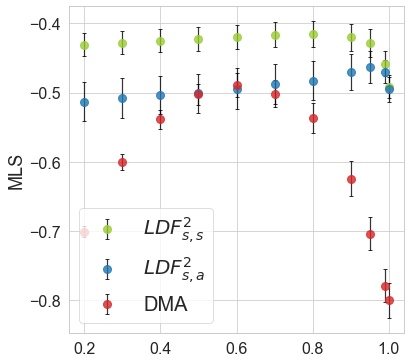

In [50]:
ldfa_df = df_res1[df_res1.index.str.contains("ldfa")]
ldfa_df.index = [float(i[1]) for i in ldfa_df.index.str.split("_")]
ldfs_df = df_res1[df_res1.index.str.contains("ldfs")]
ldfs_df.index = [float(i[1]) for i in ldfs_df.index.str.split("_")]
dma_df = df_res1[df_res1.index.str.contains("dma")]
dma_df.index = [float(i[1]) for i in dma_df.index.str.split("_")]
fig, ax = plt.subplots(1, 1, figsize=(6,6))
ax.errorbar(ldfs_df.index.to_list()[:-1], ldfs_df["mean"].to_list()[:-1], yerr=ldfs_df["std"].to_list()[:-1], fmt='o', color='yellowgreen', ecolor='black', label="$LDF_{s, s}^2$", markersize=8, alpha=0.8)
ax.errorbar(ldfa_df.index.to_list()[:-1], ldfa_df["mean"].to_list()[:-1], yerr=ldfa_df["std"].to_list()[:-1], fmt='o', color='tab:blue', ecolor='black', label="$LDF_{s, a}^2$", markersize=8, alpha=0.8)
ax.errorbar(dma_df.index.to_list()[:-1], dma_df["mean"].to_list()[:-1], yerr=dma_df["std"].to_list()[:-1], fmt='o', color='tab:red', ecolor='black', label="DMA", markersize=8, alpha=0.8)
ax.set_ylabel(r"MLS")
ax.legend(loc="lower left");

In [51]:
results_cumulative["avg"] = np.unique(np.array(results_cumulative["avg"]))

In [52]:
df_res2 = pd.concat([pd.DataFrame(results_cumulative).mean(axis=0), pd.DataFrame(results_cumulative).std(axis=0), pd.DataFrame(results_cumulative).sum(axis=0)], axis=1).rename(columns={0: "mean", 1: "std", 2: "sum"})
df_res2.style.format("{:.2f}")

,mean,std,sum
bma,-8650.01,242.51,-86500.09
avg,-2864.22,4.23,-28642.23
avg_1_5,-1404.45,45.73,-14044.47
avg_2_5,-1080.86,52.25,-10808.55
avg_3_5,-1031.68,49.74,-10316.79
avg_4_5,-1033.21,33.46,-10332.11
avg_5_5,-1063.02,31.84,-10630.20
avg_6_5,-1134.41,17.37,-11344.10
ldfa_1.0,-981.47,35.53,-9814.75
ldfa_0.99,-930.94,32.32,-9309.44


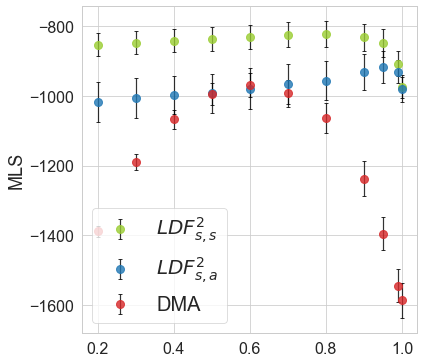

In [53]:
ldfa_df = df_res2[df_res2.index.str.contains("ldfa")]
ldfa_df.index = [float(i[1]) for i in ldfa_df.index.str.split("_")]
ldfs_df = df_res2[df_res2.index.str.contains("ldfs")]
ldfs_df.index = [float(i[1]) for i in ldfs_df.index.str.split("_")]
dma_df = df_res2[df_res2.index.str.contains("dma")]
dma_df.index = [float(i[1]) for i in dma_df.index.str.split("_")]
fig, ax = plt.subplots(1, 1, figsize=(6,6))
ax.errorbar(ldfs_df.index.to_list()[:-1], ldfs_df["mean"].to_list()[:-1], yerr=ldfs_df["std"].to_list()[:-1], fmt='o', color='yellowgreen', ecolor='black', label="$LDF_{s, s}^2$", markersize=8, alpha=0.8)
ax.errorbar(ldfa_df.index.to_list()[:-1], ldfa_df["mean"].to_list()[:-1], yerr=ldfa_df["std"].to_list()[:-1], fmt='o', color='tab:blue', ecolor='black', label="$LDF_{s, a}^2$", markersize=8, alpha=0.8)
ax.errorbar(dma_df.index.to_list()[:-1], dma_df["mean"].to_list()[:-1], yerr=dma_df["std"].to_list()[:-1], fmt='o', color='tab:red', ecolor='black', label="DMA", markersize=8, alpha=0.8)
ax.set_ylabel(r"MLS")
ax.legend(loc="lower left");